In [4]:
import subprocess
import sys


# ÈúÄË¶ÅÁöÑÂ∫ì
libraries = [
    "pandas", "numpy", "matplotlib", "torch", "scipy", "sklearn", "PIL",
    "scikit-image","ta"
]

# Ëá™Âä®ÂÆâË£ÖÁº∫Â§±ÁöÑÂ∫ì
def install_if_missing(lib_name):
    try:
        __import__(lib_name)
    except ImportError:
        print(f"Installing {lib_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib_name])

# ÈÅçÂéÜÊâÄÊúâÂ∫ìÔºåÈÄê‰∏™Ê£ÄÊü•Âπ∂ÂÆâË£Ö
for lib in libraries:
    install_if_missing(lib)

# Áé∞Âú®ÂèØ‰ª•Ê≠£Â∏∏ÂØºÂÖ•ÊâÄÊúâÂ∫ì
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import argrelmax
import os
import random
from PIL import Image
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color

print("All libraries are installed and imported successfully!")


Installing scikit-image...
Installing ta...
All libraries are installed and imported successfully!


In [5]:
import pandas as pd
import ta

# Âä†ËΩΩÊï∞ÊçÆ
data = pd.read_csv('./data.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')

# ÁßªÈô§Êó†ÊïàË°å
rows = [x for x in data.index if data.loc[x]['Open'] == 0]
data = data.drop(rows, axis=0)

# =======================
# Â¢ûÂä†ÁâπÂæÅ
# =======================

# 1. ÊäÄÊúØÊåáÊ†á
data['MA20'] = data['Close'].rolling(window=20).mean()  # 20Êó•ÁßªÂä®ÂùáÁ∫ø
data['EMA10'] = ta.trend.ema_indicator(data['Close'], window=10)  # 10Êó•ÊåáÊï∞ÁßªÂä®ÂùáÁ∫ø
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)  # RSI
data['MACD'] = ta.trend.macd(data['Close'])  # MACDÊåáÊ†á
data['Bollinger_High'] = ta.volatility.bollinger_hband(data['Close'])
data['Bollinger_Low'] = ta.volatility.bollinger_lband(data['Close'])

# 2. ÁªüËÆ°ÁâπÂæÅ
data['Close_Mean_10'] = data['Close'].rolling(window=10).mean()  # 10Êó•ÂùáÂÄº
data['Close_Std_10'] = data['Close'].rolling(window=10).std()    # 10Êó•Ê†áÂáÜÂ∑Æ
data['Daily_Return'] = data['Close'].pct_change()                # Êó•Êî∂ÁõäÁéá

# 3. Êó∂Èó¥ÁâπÂæÅ
data['day_of_week'] = data['Date'].dt.dayofweek  # Âë®Âá† (0=Monday, 6=Sunday)
data['month'] = data['Date'].dt.month            # Êúà‰ªΩ
data['quarter'] = data['Date'].dt.quarter        # Â≠£Â∫¶
data['is_month_end'] = data['Date'].dt.is_month_end.astype(int)  # ÊòØÂê¶ÊúàÊú´

# 4. Áõ∏ÂÖ≥ÊÄßÁâπÂæÅ (28Â§©ÊªöÂä®Áõ∏ÂÖ≥Á≥ªÊï∞)
data['PE_Close_Corr'] = data['Close'].rolling(window=28).corr(data['PE'])

# ÁßªÈô§Á©∫ÂÄºË°å
data = data.dropna().reset_index(drop=True)

# Êü•ÁúãÂâçÂá†Ë°åÔºåÁ°ÆËÆ§ÁâπÂæÅÁîüÊàêÊàêÂäü
print(data.head())

# ‰øùÂ≠òÂ§ÑÁêÜÂêéÁöÑÊï∞ÊçÆ
data.to_csv('./processed_data.csv', index=False)


        Date      Close       Open       High        Low     PE    MA20  \
0 1960-02-10  55.490002  55.490002  55.490002  55.490002  17.55  56.685   
1 1960-02-11  55.180000  55.180000  55.180000  55.180000  17.55  56.524   
2 1960-02-12  55.459999  55.459999  55.459999  55.459999  17.55  56.378   
3 1960-02-15  55.169998  55.169998  55.169998  55.169998  17.55  56.242   
4 1960-02-16  54.730000  54.730000  54.730000  54.730000  17.55  56.115   

       EMA10        RSI      MACD  Bollinger_High  Bollinger_Low  \
0  56.063258  31.956907 -0.859835       58.438369      54.931632   
1  55.902666  29.887143 -0.877028       58.207857      54.840143   
2  55.822181  34.042397 -0.858168       57.890476      54.865524   
3  55.703602  31.931592 -0.856746       57.673162      54.810838   
4  55.526584  28.994119 -0.880967       57.608178      54.621822   

   Close_Mean_10  Close_Std_10  Daily_Return  day_of_week  month  quarter  \
0         55.974      0.442221     -0.006268            2      

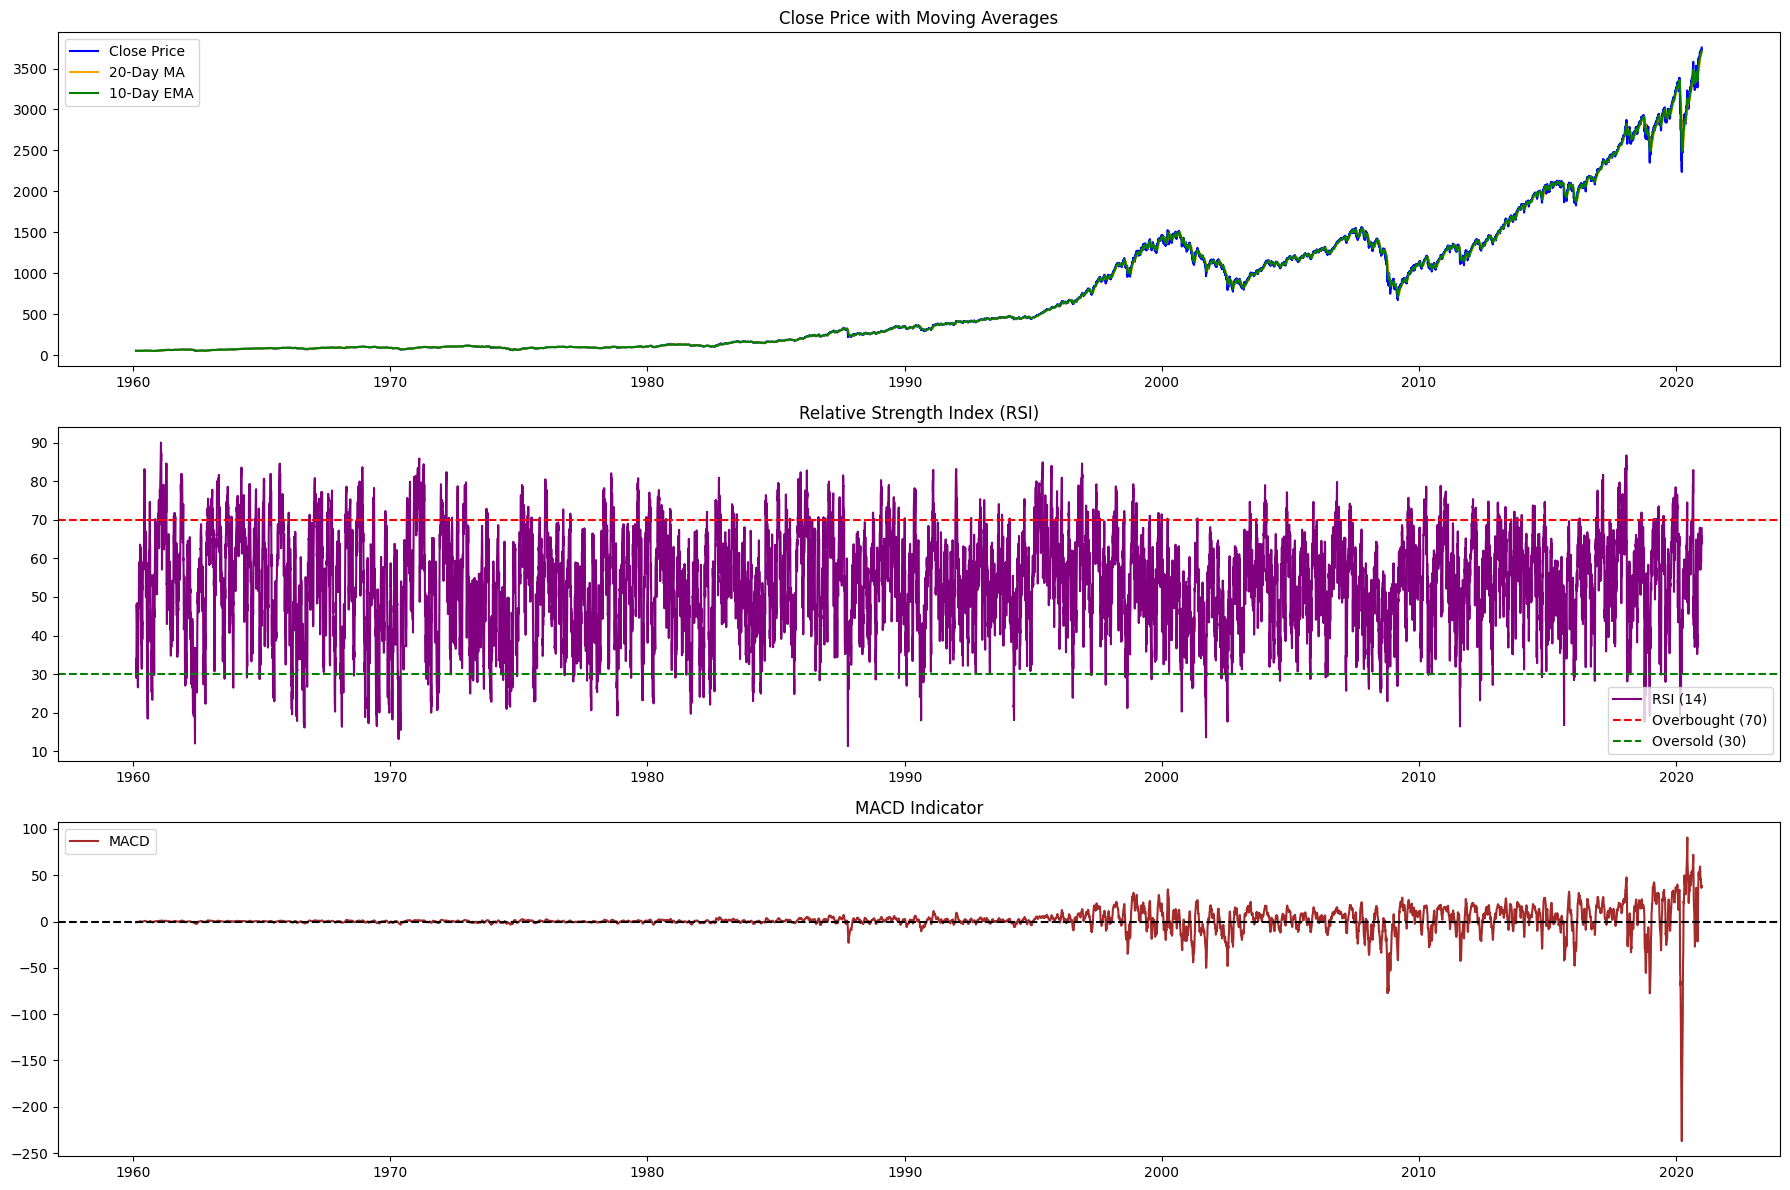

In [7]:
# 4. ÁªòÂà∂ÂõæË°®

plt.figure(figsize=(18, 12))

# (1) Êî∂Áõò‰ª∑ + ÁßªÂä®Âπ≥ÂùáÁ∫ø
plt.subplot(3, 1, 1)
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['MA20'], label='20-Day MA', color='orange')
plt.plot(data['Date'], data['EMA10'], label='10-Day EMA', color='green')
plt.title('Close Price with Moving Averages')
plt.legend()

# (2) RSI
plt.subplot(3, 1, 2)
plt.plot(data['Date'], data['RSI'], label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# (3) MACD
plt.subplot(3, 1, 3)
plt.plot(data['Date'], data['MACD'], label='MACD', color='brown')
plt.axhline(0, color='black', linestyle='--')
plt.title('MACD Indicator')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

# 1. ËØªÂèñÂ§ÑÁêÜÂêéÁöÑÊï∞ÊçÆ
data = pd.read_csv('./processed_data.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# 2. ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ
train_data = data[(data['Date'] >= '1980-01-01') & (data['Date'] <= '2019-12-31')]
test_data = data[data['Date'] >= '2020-01-01']

# 3. ‰øùÂ≠òËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# 4. ÊâìÂç∞ÂàíÂàÜÁªìÊûú
print(f"ËÆ≠ÁªÉÈõÜÂ§ßÂ∞èÔºö{len(train_data)} Ë°å")
print(f"ÊµãËØïÈõÜÂ§ßÂ∞èÔºö{len(test_data)} Ë°å")


ËÆ≠ÁªÉÈõÜÂ§ßÂ∞èÔºö10069 Ë°å
ÊµãËØïÈõÜÂ§ßÂ∞èÔºö253 Ë°å


In [11]:
# 3. ÁîüÊàê Sell ‰ø°Âè∑
curr_money = 1
money_arr = []
sell_date_arr = []

# ËÆ∞ÂΩï‰∏ä‰∏ÄÊ¨°ÂçñÂá∫Êó•
sell_day = 0  

# Âæ™ÁéØÁîüÊàêÂçñÂá∫‰ø°Âè∑
for i in range(window_size - 1, len(data)):
    curr_price = data['Close'][(i - window_size + 1):(i + 1)].values
    rsi = data.loc[i, 'RSI']
    upper_band = data.loc[i, 'Bollinger_High']
    ema10 = data.loc[i, 'EMA10']
    ma20 = data.loc[i, 'MA20']

    #Êñ∞ÁöÑÂçñÂá∫Êù°‰ª∂
    if (rsi > 70 or curr_price[-1] >= upper_band or ema10 < ma20) and (i - sell_day > window_size):
        # ÂçñÂá∫‰ª∑Ê†º
        sell_price = curr_price[-1]
        # ‰π∞ÂÖ•‰ª∑Ê†ºÔºàÂÅáËÆæ‰π∞Âú®28Â§©Á™óÂè£ÁöÑÊúÄ‰Ωé‰ª∑Ôºâ
        buy_price = min(curr_price)
        # ËÆ°ÁÆóÊî∂Áõä
        curr_money = curr_money / buy_price * sell_price
        sell_day = i  # ËÆ∞ÂΩïÂçñÂá∫Êó•Êúü
        money_arr.append(curr_money)
        sell_date_arr.append(data.loc[i, 'Date'])

# 4. ÁîüÊàê‰∫åÂÖÉÊ†áÁ≠æ (1 = Sell, 0 = Hold)
data['label'] = 0  # ÈªòËÆ§ÊåÅÊúâ
data.loc[data['Date'].isin(sell_date_arr), 'label'] = 1

# 5. ‰øùÂ≠òÁªìÊûú
data.to_csv('./labeled_data.csv', index=False)

# 6. Ê£ÄÊü•ÁªìÊûú
print(f"ÁîüÊàêÁöÑÂçñÂá∫‰ø°Âè∑Êï∞ÈáèÔºö{len(sell_date_arr)}")
print(data['label'].value_counts())
print(f"Curr MoneyÔºö{curr_money}")


ÁîüÊàêÁöÑÂçñÂá∫‰ø°Âè∑Êï∞ÈáèÔºö471
label
0    14833
1      471
Name: count, dtype: int64
Curr MoneyÔºö23167666.67777661


In [ ]:
# dataset = data[['Close']].values
# scaler = MinMaxScaler(feature_range = (0, 1))
# dataset = scaler.fit_transform(dataset)
# dataset.shape

(15355, 1)

KeyboardInterrupt: 

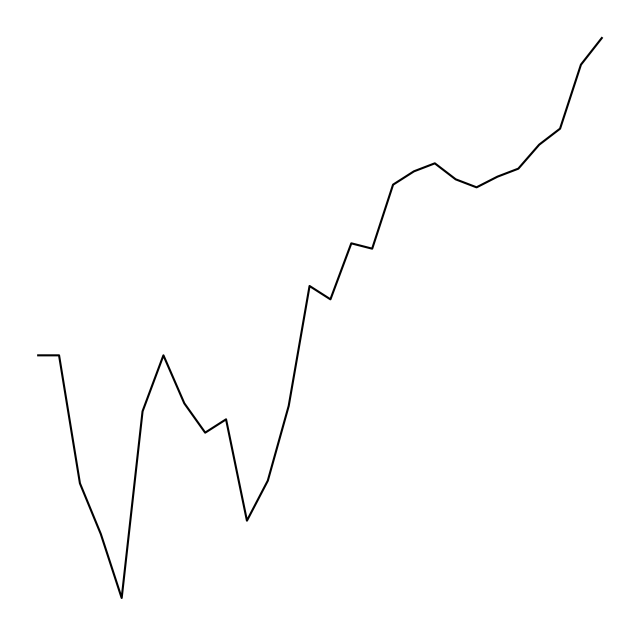

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ÂàõÂª∫Êñá‰ª∂Â§πÔºåÂ¶ÇÊûú‰∏çÂ≠òÂú®
def create_folder(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# üü¢ ÁîüÊàêÂõæÂÉèÁöÑÂáΩÊï∞
def generate_image(dataset, day_num, label, window_size):
    # 1. Ëé∑ÂèñÁ™óÂè£ÂÜÖÁöÑÊï∞ÊçÆ
    data = []
    xaxis = np.arange(0, window_size)
    for x in reversed(range(0, window_size)):
        data.append(dataset[day_num - x][0])  # ÂÅáËÆæÁ¨¨0ÂàóÊòØClose‰ª∑Ê†º

    # 2. ÁîüÊàêÂõæÂÉè
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.plot(data, color="black")

    # 3. Ê†πÊçÆÊ†áÁ≠æ‰øùÂ≠òÂà∞ÂØπÂ∫îÊñá‰ª∂Â§π
    if label == 1:
        folder = './sell_images/'  # ÂçñÂá∫
    else:
        folder = './hold_images/'  # ÊåÅÊúâ

    # ÂàõÂª∫ÂØπÂ∫îÁöÑÊñá‰ª∂Â§π
    create_folder(folder)

    # 4. ‰øùÂ≠òÂõæÂÉè
    image_name = f"{folder}day{day_num}.png"
    plt.savefig(image_name, bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close()

# ========================
# ÊâπÈáèÁîüÊàêÊâÄÊúâÊ†áÁ≠æÁöÑÂõæÂÉè
# ========================

import pandas as pd

# 1. ËØªÂèñÂ∏¶Ê†áÁ≠æÁöÑÊï∞ÊçÆ
data = pd.read_csv('./labeled_data.csv')

# 2. ËΩ¨Êç¢‰∏∫ numpy Êï∞ÁªÑ
dataset = data[['Close', 'label']].values  # Âè™Áî®CloseÂíåLabelÂàó

# 3. ËÆæÁΩÆÁ™óÂè£Â§ßÂ∞è
window_size = 28  

# 4. ÁîüÊàêÂõæÂÉè
for i in range(window_size - 1, len(dataset)):
    close_price = dataset[(i - window_size + 1):(i + 1), 0]  # ‰ª∑Ê†ºÁ™óÂè£
    label = dataset[i, 1]  # ÂçñÂá∫‰ø°Âè∑ (0=Hold, 1=Sell)
    generate_image(dataset, i, label, window_size)

print("./sell_images/ Âíå ./hold_images/")


In [14]:
# import matplotlib.pyplot as plt

# def generate_image_with_markers(dataset, i, save_directory, window_size):
#     """
#     Generate an image of the price window with buy/sell markers.
#     """
#     window_data = dataset[(i - window_size + 1):(i + 1), 0]  # Extract window data
#     x_axis = range(len(window_data))  # X-axis is just index
    
#     # Find buy/sell points
#     buy_index = window_data.argmin()  # Local min (buy)
#     sell_index = window_data.argmax()  # Local max (sell)
    
#     buy_price = window_data[buy_index]
#     sell_price = window_data[sell_index]
    
#     # Plot the price curve
#     plt.figure(figsize=(5, 5))  # Adjust figure size
#     plt.plot(x_axis, window_data, color="black", linewidth=2)  # Price line
    
#     # Highlight buy point (green circle)
#     plt.scatter(buy_index, buy_price, color="green", marker='o', s=100, label="Buy Point")
    
#     # Highlight sell point (red cross)
#     plt.scatter(sell_index, sell_price, color="red", marker='x', s=100, label="Sell Point")
    
#     plt.axis('off')  # Remove axes
#     plt.legend()  # Add legend
    
#     # Save the image
#     save_path = f"{save_directory}/day{i}.png"
#     plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

# Example usage:
# generate_image_with_markers(dataset, i, "train_sell_point_image", window_size)


In [ ]:
#Create the CandaidateTrain folder manually, then run this to create all possible selling signals
# train_sell_image_directory = 'train_sell_point_image/'
# if not os.path.exists(train_sell_image_directory ):
#     os.makedirs(train_sell_image_directory )

# for i in cnn_sell_point_arr:
#     #generate_image(dataset,i,train_sell_image_directory, window_size)
#     generate_image(dataset,i,train_sell_image_directory, window_size)

<Figure size 800x800 with 0 Axes>

In [ ]:
# not sell 
# cnn_hold_point_arr = []
# prev_hold_point = 0 # ‰∏ä‰∏Ä‰∏™holdÁÇπÁöÑ‰∏ãÊ†á
# for i in range(window_size-1,len(dataset)):
# #     1. corr < -0.5
# #     2. ÂΩìÂâçholdÁÇπÂíåÂâçÂá†‰∏™Èó¥Èöî28Â§©
# #     3. ÂΩìÂâçholdÁÇπÁöÑ‰ª∑Ê†º‰∏çËÉΩÊòØÂΩìÂâçwindowÁöÑÊúÄÈ´òÁÇπ
#     if step2_data_corr[i][2] < -0.5  and i >= prev_hold_point + window_size and dataset[i][0] < max(dataset[(i-window_size+1):(i+1), 0]):
#         cnn_hold_point_arr.append(i)
#         prev_hold_point = i
# #Now, we have a candidate not selling signal list
# len(cnn_hold_point_arr)

51

In [ ]:
# train_hold_image_directory = 'train_hold_point_image/'
# if not os.path.exists(train_hold_image_directory ):
#     os.makedirs(train_hold_image_directory)

# for i in cnn_hold_point_arr:
#     #generate_image(dataset, i, train_hold_image_directory, window_size)
#     generate_image(dataset, i, train_hold_image_directory, window_size)



<Figure size 800x800 with 0 Axes>

In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Êñá‰ª∂Â§πË∑ØÂæÑ
train_sell_image_directory = './sell_images/'  # ÂçñÂá∫ÂõæÂÉèË∑ØÂæÑ
train_hold_image_directory = './hold_images/'  # ÊåÅÊúâÂõæÂÉèË∑ØÂæÑ

# üü¢ 1. ËØªÂèñÊï∞ÊçÆ
data = pd.read_csv('./labeled_data.csv')

# üü¢ 2. ÁîüÊàêÂçñÂá∫ÂíåÊåÅÊúâÁöÑÁ¥¢Âºï
sell_point_indices = data[data['label'] == 1].index.tolist()  # ÂçñÂá∫ÁÇπ
hold_point_indices = data[data['label'] == 0].index.tolist()  # ÊåÅÊúâÁÇπ

# ============================
# üü° 3. ÁîüÊàêËæìÂÖ•ÂíåÊ†áÁ≠æ
# ============================
cnn_input = []
cnn_label = []

# üöÄ Â§ÑÁêÜÂçñÂá∫ÂõæÂÉè (label = 1)
for img_index in sell_point_indices:
    image_path = os.path.join(train_sell_image_directory, f'day{img_index}.png')
    if os.path.exists(image_path):
        img = Image.open(image_path)
        img = img.convert("L")  # ÁÅ∞Â∫¶
        img_resize = img.resize((180, 180))  # Áªü‰∏ÄÂ∞∫ÂØ∏
        cnn_input.append(np.asarray(img_resize) / 255.0)  # ÂΩí‰∏ÄÂåñ
        cnn_label.append(1)  # ÂçñÂá∫Ê†áÁ≠æ

# üöÄ Â§ÑÁêÜÊåÅÊúâÂõæÂÉè (label = 0)
for img_index in hold_point_indices:
    image_path = os.path.join(train_hold_image_directory, f'day{img_index}.png')
    if os.path.exists(image_path):
        img = Image.open(image_path)
        img = img.convert("L")
        img_resize = img.resize((180, 180))
        cnn_input.append(np.asarray(img_resize) / 255.0)
        cnn_label.append(0)  # ÊåÅÊúâÊ†áÁ≠æ

# ============================
# üî¢ 4. ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑ
# ============================
cnn_input = np.array(cnn_input)
cnn_label = np.array(cnn_label)

print(f"üìè CNN ËæìÂÖ•ÂΩ¢Áä∂Ôºö{cnn_input.shape}")
print(f"üîñ CNN Ê†áÁ≠æÂΩ¢Áä∂Ôºö{cnn_label.shape}")

# ============================
# üü° 5. ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜ (80/20 Split)
# ============================
cnn_train_input = []
cnn_train_label = []
cnn_val_input = []
cnn_val_label = []

# üöÄ ÂàíÂàÜÊï∞ÊçÆ
for i in range(cnn_input.shape[0]):
    if i % 5 == 4:  # 20% È™åËØÅÈõÜ
        cnn_val_input.append(cnn_input[i])
        cnn_val_label.append(cnn_label[i])
    else:  # 80% ËÆ≠ÁªÉÈõÜ
        cnn_train_input.append(cnn_input[i])
        cnn_train_label.append(cnn_label[i])

# üü¢ ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑ
cnn_train_input = np.array(cnn_train_input)
cnn_train_label = np.array(cnn_train_label)
cnn_val_input = np.array(cnn_val_input)
cnn_val_label = np.array(cnn_val_label)

# ============================
# ‚úÖ 6. È™åËØÅËæìÂá∫
# ============================
print(f"‚úÖ ËÆ≠ÁªÉÈõÜËæìÂÖ•Ôºö{cnn_train_input.shape}, ËÆ≠ÁªÉÈõÜÊ†áÁ≠æÔºö{cnn_train_label.shape}")
print(f"‚úÖ È™åËØÅÈõÜËæìÂÖ•Ôºö{cnn_val_input.shape}, È™åËØÅÈõÜÊ†áÁ≠æÔºö{cnn_val_label.shape}")



üìè CNN ËæìÂÖ•ÂΩ¢Áä∂Ôºö(15277, 180, 180)
üîñ CNN Ê†áÁ≠æÂΩ¢Áä∂Ôºö(15277,)
‚úÖ ËÆ≠ÁªÉÈõÜËæìÂÖ•Ôºö(12222, 180, 180), ËÆ≠ÁªÉÈõÜÊ†áÁ≠æÔºö(12222,)
‚úÖ È™åËØÅÈõÜËæìÂÖ•Ôºö(3055, 180, 180), È™åËØÅÈõÜÊ†áÁ≠æÔºö(3055,)


In [18]:
import torch
import numpy as np

# ============================
# üü¢ 1. ËΩ¨Êç¢ËÆ≠ÁªÉÈõÜ‰∏∫ Torch Ê†ºÂºè
# ============================

# Â∞ÜËæìÂÖ• reshaped ‰∏∫ (batch_size, channels, height, width)
cnn_train_input = cnn_train_input.reshape(cnn_train_input.shape[0], 1, cnn_train_input.shape[1], cnn_train_input.shape[2])
cnn_train_input = torch.from_numpy(cnn_train_input.astype(np.float32))

# Â∞ÜÊ†áÁ≠æËΩ¨Êç¢‰∏∫Êï¥Êï∞Á±ªÂûãÁöÑ Tensor
cnn_train_label = torch.from_numpy(cnn_train_label.astype(int))

# ============================
# üü° 2. ËΩ¨Êç¢È™åËØÅÈõÜ‰∏∫ Torch Ê†ºÂºè
# ============================

cnn_val_input = cnn_val_input.reshape(cnn_val_input.shape[0], 1, cnn_val_input.shape[1], cnn_val_input.shape[2])
cnn_val_input = torch.from_numpy(cnn_val_input.astype(np.float32))

cnn_val_label = torch.from_numpy(cnn_val_label.astype(int))

# ============================
# ‚úÖ 3. ÊâìÂç∞ÂΩ¢Áä∂‰ª•È™åËØÅ
# ============================

print(f"‚úÖ ËÆ≠ÁªÉÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºö{cnn_train_input.shape}, ËÆ≠ÁªÉÈõÜÊ†áÁ≠æÂΩ¢Áä∂Ôºö{cnn_train_label.shape}")
print(f"‚úÖ È™åËØÅÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºö{cnn_val_input.shape}, È™åËØÅÈõÜÊ†áÁ≠æÂΩ¢Áä∂Ôºö{cnn_val_label.shape}")


‚úÖ ËÆ≠ÁªÉÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºötorch.Size([12222, 1, 180, 180]), ËÆ≠ÁªÉÈõÜÊ†áÁ≠æÂΩ¢Áä∂Ôºötorch.Size([12222])
‚úÖ È™åËØÅÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºötorch.Size([3055, 1, 180, 180]), È™åËØÅÈõÜÊ†áÁ≠æÂΩ¢Áä∂Ôºötorch.Size([3055])


In [22]:
import torch
import torch.nn as nn

class CNN(nn.Module):   
    def __init__(self):
        super(CNN, self).__init__()
        
        # üü¢ 1. Âç∑ÁßØÂ±Ç 1
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)  # 1 ËæìÂÖ•ÈÄöÈÅì ‚Üí 8 ËæìÂá∫ÈÄöÈÅì
        self.batch1 = nn.BatchNorm2d(8)
        self.activate1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)  # 180 ‚Üí 90

        # üü° 2. Âç∑ÁßØÂ±Ç 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # 8 ‚Üí 16
        self.batch2 = nn.BatchNorm2d(16)
        self.activate2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)  # 90 ‚Üí 45

        # üü£ 3. Flatten Â±ÇÔºàËá™Âä®ËÆ°ÁÆóÁª¥Â∫¶Ôºâ
        self.flatten = nn.Flatten()

        # üîµ 4. ÂÖ®ËøûÊé•Â±Ç
        self.linear1 = nn.Linear(45 * 45 * 16, 128)  # Ëá™Âä®ËÆ°ÁÆóÁöÑÁª¥Â∫¶
        self.activate3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(128, 2)  # ËæìÂá∫‰∫åÂàÜÁ±ªÔºàHold vs. SellÔºâ

    # üü† Forward Pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.activate1(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.activate2(x)
        x = self.max_pool2(x)

        x = self.flatten(x)  # Ëá™Âä®Â±ïÂºÄ
        x = self.linear1(x)
        x = self.activate3(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


In [33]:
# #set seed for reproducible results
# torch.manual_seed(1)
# np.random.seed(1)
# random.seed(1)
# defining the model
cnn_learning_rate = 0.001
cnn_training_epochs = 40
cnn_model = CNN().double()
# defining the optimizer
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=cnn_learning_rate)
# defining the loss function
# ËÆ°ÁÆóÁ±ªÂà´ÊùÉÈáçÔºöHold = 11845ÔºåSell = 377
class_weights = torch.tensor([1.0, 11845 / 377], dtype=torch.float32).to(cnn_train_input.device)

# Âä†ÊùÉ‰∫§ÂèâÁÜµ
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Â∞ÜÊ®°ÂûãÊùÉÈáçÂíåÂÅèÁΩÆËΩ¨Êç¢‰∏∫ float32
cnn_model = CNN().to(torch.float32)
cnn_model

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activate1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activate2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32400, out_features=128, bias=True)
  (activate3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [34]:
print(cnn_train_label.shape)
print(cnn_train_input.shape)

torch.Size([12222])
torch.Size([12222, 1, 180, 180])


In [35]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

# üü¢ 1. ÂàõÂª∫ DataLoader (ÊâπÈáèËÆ≠ÁªÉ)
batch_size = 64

train_dataset = TensorDataset(cnn_train_input, cnn_train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(cnn_val_input, cnn_val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# üü° 2. ËÆ≠ÁªÉËÆæÁΩÆ
cnn_training_epochs = 50
train_loss_arr = []
val_loss_arr = []

# üü£ 3. ËÆ≠ÁªÉËøáÁ®ã
for epoch in range(cnn_training_epochs):
    cnn_model.train()  # ËÆ≠ÁªÉÊ®°Âºè
    train_loss = 0.0

    # üöÄ 3.1 ËÆ≠ÁªÉÈò∂ÊÆµ
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()
        output_train = cnn_model(inputs)

        loss = criterion(output_train, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_arr.append(train_loss)

    # üü† 3.2 È™åËØÅÈò∂ÊÆµ (ÂÖ≥Èó≠Ê¢ØÂ∫¶ËÆ°ÁÆó)
    cnn_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

            output_val = cnn_model(val_inputs)
            loss_val = criterion(output_val, val_labels)

            val_loss += loss_val.item()

    val_loss /= len(val_loader)
    val_loss_arr.append(val_loss)

    # ‚úÖ 4. ÊâìÂç∞ÁªìÊûú
    if epoch % 10 == 0 or epoch == cnn_training_epochs - 1:
        print(f"[{epoch}/{cnn_training_epochs}] Training Loss: {train_loss:.4f}")
        print(f"[{epoch}/{cnn_training_epochs}] Validation Loss: {val_loss:.4f}")

print("üéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ")

    

[0/50] Training Loss: 0.6918
[0/50] Validation Loss: 0.6196
[10/50] Training Loss: 0.6992
[10/50] Validation Loss: 0.6196
[20/50] Training Loss: 0.6956
[20/50] Validation Loss: 0.6195
[30/50] Training Loss: 0.6966
[30/50] Validation Loss: 0.6196
[40/50] Training Loss: 0.6914
[40/50] Validation Loss: 0.6196
[49/50] Training Loss: 0.6915
[49/50] Validation Loss: 0.6196
üéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ


<module 'matplotlib.pyplot' from 'c:\\Users\\yehang\\anaconda3\\envs\\MyPython\\Lib\\site-packages\\matplotlib\\pyplot.py'>

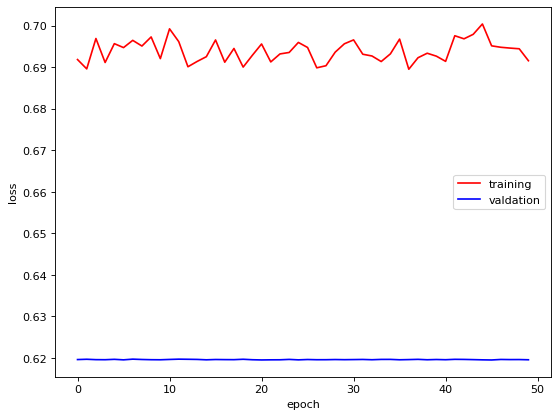

In [36]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(train_loss_arr), 'red', label = 'training')
plt.plot(np.array(val_loss_arr), 'blue', label = 'valdation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt

In [37]:
unique, counts = torch.unique(cnn_train_label, return_counts=True)
print(f"ËÆ≠ÁªÉÈõÜÊ†áÁ≠æÂàÜÂ∏ÉÔºö{dict(zip(unique.tolist(), counts.tolist()))}")


ËÆ≠ÁªÉÈõÜÊ†áÁ≠æÂàÜÂ∏ÉÔºö{0: 11845, 1: 377}


In [38]:
# üü¢ 1. ËØÑ‰º∞Ê®°Âºè
cnn_model.eval()

# üü° 2. ËÆ≠ÁªÉÈõÜÈ¢ÑÊµã
with torch.no_grad():
    output = cnn_model(cnn_train_input)
    _, prediction = torch.max(output, axis=1)

# üü£ 3. ËÆ°ÁÆóÂáÜÁ°ÆÁéá
correct_num = (prediction == cnn_train_label).sum().item()  # Áõ¥Êé•ÁªüËÆ°Ê≠£Á°ÆÊï∞
train_accuracy = correct_num / cnn_train_label.size(0)

# ‚úÖ 4. ËæìÂá∫ÁªìÊûú
print(f"‚úÖ ËÆ≠ÁªÉÈõÜÂáÜÁ°ÆÁéáÔºö{train_accuracy:.4f}")

‚úÖ ËÆ≠ÁªÉÈõÜÂáÜÁ°ÆÁéáÔºö0.8012


In [39]:
# üü¢ 1. ÂàáÊç¢‰∏∫ËØÑ‰º∞Ê®°Âºè
cnn_model.eval()

# üü° 2. È¢ÑÊµãÈ™åËØÅÈõÜ
with torch.no_grad():
    output = cnn_model(cnn_val_input)
    _, prediction = torch.max(output, axis=1)

# üü£ 3. ËÆ°ÁÆóÂáÜÁ°ÆÁéá
correct_num = (prediction == cnn_val_label).sum().item()
val_accuracy = correct_num / cnn_val_label.size(0)

# ‚úÖ 4. ËæìÂá∫ÁªìÊûú
print(f"‚úÖ È™åËØÅÈõÜÂáÜÁ°ÆÁéáÔºö{val_accuracy:.4f}")


‚úÖ È™åËØÅÈõÜÂáÜÁ°ÆÁéáÔºö0.8092


In [56]:
# ÁîüÊàê RNN ËæìÂÖ• (28 Â§©Á™óÂè£)
seq_len = 28
X, y = [], []

for i in range(len(data) - seq_len):
    # Áõ¥Êé•‰ΩøÁî® label Âàó
    X.append(data[['Close', 'label']].iloc[i:i + seq_len].values)
    y.append(data['Close'].iloc[i + seq_len])  # È¢ÑÊµã‰∏ã‰∏ÄÂ§©ÁöÑ Close

X = np.array(X)  # (Ê†∑Êú¨Êï∞, 28, 2)
y = np.array(y)  # (Ê†∑Êú¨Êï∞,)

print(f"ËæìÂÖ•ÂΩ¢Áä∂Ôºö{X.shape}, ÁõÆÊ†áÂΩ¢Áä∂Ôºö{y.shape}")





ËæìÂÖ•ÂΩ¢Áä∂Ôºö(15276, 28, 3), ÁõÆÊ†áÂΩ¢Áä∂Ôºö(15276,)


In [59]:
date = data[['Date']].values
date.shape

(15304, 1)

In [60]:
test_date = test_data[['Date']].values
test_date.shape

(253, 1)

In [64]:
rnn_hidden_size = 50
rnn_num_layers = 1
rnn_training_epochs = 200
rnn_learning_rate = 0.001
rnn_output_size = 1

In [65]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers        
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
#         print(x.shape)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        res, hidden = self.rnn(x, hidden)
        res = self.linear(res)
        return res[:, -1, :], hidden
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

In [79]:
# # Âà†Èô§Â§ö‰ΩôÁöÑ 'label' Âàó
# data = data.iloc[:,:-1]

# # Ê£ÄÊü•ÂàóÂêç
# print(data.columns)


Index(['Date', 'Close', 'Open', 'High', 'Low', 'PE', 'MA20', 'EMA10', 'RSI',
       'MACD', 'Bollinger_High', 'Bollinger_Low', 'Close_Mean_10',
       'Close_Std_10', 'Daily_Return', 'day_of_week', 'month', 'quarter',
       'is_month_end', 'PE_Close_Corr', 'label'],
      dtype='object')


In [80]:
import numpy as np

# 1. ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑ
features = data[['Close', 'label']].values
targets = data['Close'].values

# 2. ÁîüÊàêÊªëÂä®Á™óÂè£ËæìÂÖ•
seq_len = 28
X, y = [], []

for i in range(len(features) - seq_len):
    X.append(features[i:i + seq_len])  # Ââç28Â§©ÁâπÂæÅ
    y.append(targets[i + seq_len])     # Á¨¨29Â§©Close

X = np.array(X)  # (Ê†∑Êú¨Êï∞, 28, 2)
y = np.array(y)  # (Ê†∑Êú¨Êï∞,)

print(f"ËæìÂÖ• X ÂΩ¢Áä∂Ôºö{X.shape}, ÁõÆÊ†á y ÂΩ¢Áä∂Ôºö{y.shape}")


ËæìÂÖ• X ÂΩ¢Áä∂Ôºö(15276, 28, 2), ÁõÆÊ†á y ÂΩ¢Áä∂Ôºö(15276,)


In [102]:
from sklearn.preprocessing import MinMaxScaler

## 1. ÂàùÂßãÂåñÂΩí‰∏ÄÂåñÂô®
#scaler = MinMaxScaler(feature_range=(0, 1))
#
## 2. ‰ªÖÂΩí‰∏ÄÂåñ Close Âàó
#data['Close'] = scaler.fit_transform(data[['Close']])

data["Close_transformed"] = data["Close"].pct_change()


# 3. ÁîüÊàêËÆ≠ÁªÉÊï∞ÊçÆ
X, y = [], []
for i in range(1, len(data) - seq_len):
    X.append(data[['Close_transformed', 'label']].iloc[i:i + seq_len].values)  # Close (Â∑≤ÂΩí‰∏ÄÂåñ) + label (0/1)
    y.append(data['Close_transformed'].iloc[i + seq_len])                      # È¢ÑÊµã‰∏ã‰∏ÄÂ§© Close

X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32).view(-1, 1)

print(f"ËæìÂÖ• X ÂΩ¢Áä∂Ôºö{X.shape}, ÁõÆÊ†á y ÂΩ¢Áä∂Ôºö{y.shape}")



ËæìÂÖ• X ÂΩ¢Áä∂Ôºötorch.Size([15275, 28, 2]), ÁõÆÊ†á y ÂΩ¢Áä∂Ôºötorch.Size([15275, 1])


In [104]:
import torch.nn as nn
import torch.optim as optim

# ÊçüÂ§±ÂáΩÊï∞
criterion = nn.MSELoss()

# ‰ºòÂåñÂô®
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [105]:
from sklearn.model_selection import train_test_split

# ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ËΩ¨Êç¢‰∏∫ PyTorch Âº†Èáè
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(f"ËÆ≠ÁªÉÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºö{X_train.shape}, ËÆ≠ÁªÉÈõÜÁõÆÊ†áÂΩ¢Áä∂Ôºö{y_train.shape}")
print(f"ÊµãËØïÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºö{X_test.shape}, ÊµãËØïÈõÜÁõÆÊ†áÂΩ¢Áä∂Ôºö{y_test.shape}")


ËÆ≠ÁªÉÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºötorch.Size([12220, 28, 2]), ËÆ≠ÁªÉÈõÜÁõÆÊ†áÂΩ¢Áä∂Ôºötorch.Size([12220, 1])
ÊµãËØïÈõÜËæìÂÖ•ÂΩ¢Áä∂Ôºötorch.Size([3055, 28, 2]), ÊµãËØïÈõÜÁõÆÊ†áÂΩ¢Áä∂Ôºötorch.Size([3055, 1])


C:\Users\yehang\AppData\Local\Temp\ipykernel_33984\3206820862.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\yehang\AppData\Local\Temp\ipykernel_33984\3206820862.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
C:\Users\yehang\AppData\Local\Temp\ipykernel_33984\3206820862.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\yehang\AppData\Local\Tem

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# ÂàùÂßãÂåñÊ®°Âûã„ÄÅÊçüÂ§±ÂáΩÊï∞Âíå‰ºòÂåñÂô®
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(input_size=2, hidden_size=64, output_size=1, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ËÆ≠ÁªÉÂèÇÊï∞
rnn_training_epochs = 100
batch_size = 64

# ËÆ∞ÂΩïËÆ≠ÁªÉÂíåÈ™åËØÅÊçüÂ§±
rnn_train_loss_arr = []
rnn_val_loss_arr = []

# ËÆ≠ÁªÉÊ®°Âûã
for epoch in range(rnn_training_epochs):
    model.train()
    total_train_loss = 0.0

    # Â∞ÜËæìÂÖ•ÂíåÊ†áÁ≠æËΩ¨Êç¢‰∏∫ Variable
    rnn_train_inputv = Variable(X_train).to(device)
    rnn_train_labelv = Variable(y_train).to(device)

    # 1. ÂâçÂêë‰º†Êí≠
    output_train, _ = model(rnn_train_inputv)

    # 2. ËÆ°ÁÆóËÆ≠ÁªÉÊçüÂ§±
    loss = criterion(output_train.reshape(-1), rnn_train_labelv.view(-1))
    rnn_train_loss_arr.append(loss.item())
    total_train_loss += loss.item()

    # 3. ÂèçÂêë‰º†Êí≠
    optimizer.zero_grad()
    loss.backward()

    # 4. Êõ¥Êñ∞ÊùÉÈáç
    optimizer.step()

    # È™åËØÅËøáÁ®ã
    model.eval()
    with torch.no_grad():
        rnn_val_inputv = Variable(X_test).to(device)
        rnn_val_labelv = Variable(y_test).to(device)

        # ÂâçÂêë‰º†Êí≠
        output_val ,_= model(rnn_val_inputv)

        # ËÆ°ÁÆóÈ™åËØÅÊçüÂ§±
        loss_val = criterion(output_val.reshape(-1), rnn_val_labelv.view(-1))
        rnn_val_loss_arr.append(loss_val.item())

    # ÊØè10‰∏™epochÊâìÂç∞‰∏ÄÊ¨°ÊçüÂ§±
    if (epoch % 10 == 0 or epoch == rnn_training_epochs - 1):
        print(f"[{epoch}/{rnn_training_epochs}] ËÆ≠ÁªÉÊçüÂ§±: {loss.item():.7f}, È™åËØÅÊçüÂ§±: {loss_val.item():.7f}")

print("üéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ")


[0/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0012046, È™åËØÅÊçüÂ§±: 0.0006281
[10/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0001573, È™åËØÅÊçüÂ§±: 0.0001706
[20/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0001176, È™åËØÅÊçüÂ§±: 0.0001627
[30/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0001049, È™åËØÅÊçüÂ§±: 0.0001593
[40/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0001007, È™åËØÅÊçüÂ§±: 0.0001575
[50/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000996, È™åËØÅÊçüÂ§±: 0.0001575
[60/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000983, È™åËØÅÊçüÂ§±: 0.0001546
[70/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000967, È™åËØÅÊçüÂ§±: 0.0001537
[80/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000958, È™åËØÅÊçüÂ§±: 0.0001533
[90/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000955, È™åËØÅÊçüÂ§±: 0.0001531
[99/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000952, È™åËØÅÊçüÂ§±: 0.0001532
üéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ


In [ ]:
# Begin test for CNN + RNN using test_data

In [109]:
##Converting the test dataset into imgae

# ÂàõÂª∫‰øùÂ≠òÊµãËØïÂõæÁâáÁöÑÊñá‰ª∂Â§π
test_image_dir = './test_images/'
os.makedirs(test_image_dir, exist_ok=True)

# ÁîüÊàêÊµãËØïÈõÜÂõæÁâá
window_size = 28
for i in range(window_size, len(test_data)):
    data_window = test_data['Close'].iloc[i - window_size:i]

    plt.figure(figsize=(8, 8))
    plt.plot(data_window, color='black')
    plt.axis('off')  # ‰∏çÊòæÁ§∫ÂùêÊ†áËΩ¥
    plt.savefig(f"{test_image_dir}day{i}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"‚úÖ ÊµãËØïÈõÜÂõæÁâáÁîüÊàêÂÆåÊàêÔºå‰øùÂ≠ò‰∫éÔºö{test_image_dir}")


‚úÖ ÊµãËØïÈõÜÂõæÁâáÁîüÊàêÂÆåÊàêÔºå‰øùÂ≠ò‰∫éÔºö./test_images/


In [110]:

# ËØªÂèñÊµãËØïÈõÜÂõæÁâáÂπ∂ËΩ¨Êç¢‰∏∫ CNN ËæìÂÖ•
cnn_test_input = []

for i in range(window_size, len(test_data)):
    image_path = f"{test_image_dir}day{i}.png"
    img = Image.open(image_path)
    img = img.convert("L")  # ËΩ¨‰∏∫ÁÅ∞Â∫¶Âõæ
    img_resize = img.resize((180, 180))  # Ë∞ÉÊï¥‰∏∫CNNÊúüÊúõÁöÑÂ∞∫ÂØ∏
    cnn_test_input.append(np.asarray(img_resize) / 255.0)

# ËΩ¨Êç¢‰∏∫ PyTorch Âº†Èáè
cnn_test_input = torch.tensor(np.array(cnn_test_input), dtype=torch.float32).view(-1, 1, 180, 180).to(device)

print(f"ÊµãËØïËæìÂÖ•ÂΩ¢Áä∂Ôºö{cnn_test_input.shape}")


ÊµãËØïËæìÂÖ•ÂΩ¢Áä∂Ôºötorch.Size([225, 1, 180, 180])


In [119]:
test_data

Date    Close     Open     High      Low     PE       MA20  \
15051 2020-01-02  3257.85  3244.67  3258.14  3235.53  30.99  3188.1260   
15052 2020-01-03  3234.85  3226.36  3246.15  3222.34  30.99  3194.2305   
15053 2020-01-06  3246.28  3217.55  3246.84  3214.64  30.99  3200.6730   
15054 2020-01-07  3237.18  3241.86  3244.91  3232.43  30.99  3205.2365   
15055 2020-01-08  3253.05  3238.59  3267.07  3236.67  30.99  3211.0910   
...          ...      ...      ...      ...      ...    ...        ...   
15299 2020-12-24  3703.06  3694.03  3703.82  3689.32  33.77  3680.3145   
15300 2020-12-28  3735.36  3723.03  3740.51  3723.03  33.77  3685.1650   
15301 2020-12-29  3727.04  3750.01  3756.12  3723.31  33.77  3690.4355   
15302 2020-12-30  3732.04  3736.19  3744.63  3730.21  33.77  3693.9150   
15303 2020-12-31  3756.07  3733.27  3760.20  3726.88  33.77  3698.2680   

             EMA10        RSI       MACD  ...  Close_Mean_10  Close_Std_10  \
15051  3223.101422  75.483057  36.192742  ...       3225.497     18.623351   
15052  3225.237527  65.738926  34.913483  ...       3229.868     14.288618   
15053  3229.063431  67.952962  34.425134  ...       3233.959     12.198909   
15054  3230.539171  64.385561  32.924290  ...       3235.555     11.362419   
15055  3234.632049  67.581890  32.639192  ...       3238.459     11.786984   
...            ...        ...        ...  ...            ...           ...   
15299  3691.201113  61.278722  36.431219  ...       3691.388     21.787600   
15300  3699.230001  65.834249  37.531539  ...       3698.578     23.354510   
15301  3704.286365  63.753598  37.302198  ...       3706.533     16.587076   
15302  3709.332480  64.480123  37.096280  ...       3710.275     17.779019   
15303  3717.830211  67.818671  38.429122  ...       3715.765     22.503633   

       Daily_Return  day_of_week  month  quarter  is_month_end  PE_Close_Corr  \
15051      0.008379            3      1        1             0       0.523066   
15052     -0.007060            4      1        1             0       0.524455   
15053      0.003533            0      1        1             0       0.535793   
15054     -0.002803            1      1        1             0       0.544707   
15055      0.004902            2      1        1             0       0.567625   
...             ...          ...    ...      ...           ...            ...   
15299      0.003537            3     12        4             0       0.858996   
15300      0.008723            0     12        4             0       0.854354   
15301     -0.002227            1     12        4             0       0.845075   
15302      0.001342            2     12        4             0       0.823732   
15303      0.006439            3     12        4             1       0.782147   

       Sell_Label  label  
15051           0      0  
15052           0      0  
15053           0      0  
15054           0      0  
15055           0      0  
...           ...    ...  
15299           0      0  
15300           0      0  
15301           0      0  
15302           0      0  
15303           0      0  

[253 rows x 22 columns]

In [120]:
cnn_model.eval()
with torch.no_grad():
    cnn_output = cnn_model(cnn_test_input)
    _, sell_label = torch.max(cnn_output, axis=1)

# 5Ô∏è‚É£ Ë°• 0 Â§ÑÁêÜÂâç28Â§©ÁöÑÁ©∫Áº∫
sell_label_full = np.zeros(len(test_data))
sell_label_full[window_size:window_size + len(sell_label)] = sell_label.cpu().numpy()

# 6Ô∏è‚É£ Â∞Ü Sell Label Ê∑ªÂä†Âà∞ÊµãËØïÊï∞ÊçÆ
test_data['label'] = sell_label_full.astype(int)

In [125]:
count_ones = test_data['label'].sum()
print(f"Count of 1s in test_data label column: {count_ones}")


Count of 1s in test_data label column: 30


In [135]:
test_data["Close_transformed"] = test_data["Close"].pct_change()
test_data

Date    Close     Open     High      Low     PE       MA20  \
15051 2020-01-02  3257.85  3244.67  3258.14  3235.53  30.99  3188.1260   
15052 2020-01-03  3234.85  3226.36  3246.15  3222.34  30.99  3194.2305   
15053 2020-01-06  3246.28  3217.55  3246.84  3214.64  30.99  3200.6730   
15054 2020-01-07  3237.18  3241.86  3244.91  3232.43  30.99  3205.2365   
15055 2020-01-08  3253.05  3238.59  3267.07  3236.67  30.99  3211.0910   
...          ...      ...      ...      ...      ...    ...        ...   
15299 2020-12-24  3703.06  3694.03  3703.82  3689.32  33.77  3680.3145   
15300 2020-12-28  3735.36  3723.03  3740.51  3723.03  33.77  3685.1650   
15301 2020-12-29  3727.04  3750.01  3756.12  3723.31  33.77  3690.4355   
15302 2020-12-30  3732.04  3736.19  3744.63  3730.21  33.77  3693.9150   
15303 2020-12-31  3756.07  3733.27  3760.20  3726.88  33.77  3698.2680   

             EMA10        RSI       MACD  ...  Close_Std_10  Daily_Return  \
15051  3223.101422  75.483057  36.192742  ...     18.623351      0.008379   
15052  3225.237527  65.738926  34.913483  ...     14.288618     -0.007060   
15053  3229.063431  67.952962  34.425134  ...     12.198909      0.003533   
15054  3230.539171  64.385561  32.924290  ...     11.362419     -0.002803   
15055  3234.632049  67.581890  32.639192  ...     11.786984      0.004902   
...            ...        ...        ...  ...           ...           ...   
15299  3691.201113  61.278722  36.431219  ...     21.787600      0.003537   
15300  3699.230001  65.834249  37.531539  ...     23.354510      0.008723   
15301  3704.286365  63.753598  37.302198  ...     16.587076     -0.002227   
15302  3709.332480  64.480123  37.096280  ...     17.779019      0.001342   
15303  3717.830211  67.818671  38.429122  ...     22.503633      0.006439   

       day_of_week  month  quarter  is_month_end  PE_Close_Corr  Sell_Label  \
15051            3      1        1             0       0.523066           0   
15052            4      1        1             0       0.524455           0   
15053            0      1        1             0       0.535793           0   
15054            1      1        1             0       0.544707           0   
15055            2      1        1             0       0.567625           0   
...            ...    ...      ...           ...            ...         ...   
15299            3     12        4             0       0.858996           0   
15300            0     12        4             0       0.854354           0   
15301            1     12        4             0       0.845075           0   
15302            2     12        4             0       0.823732           0   
15303            3     12        4             1       0.782147           0   

       label  Close_transformed  
15051      0                NaN  
15052      0          -0.007060  
15053      0           0.003533  
15054      0          -0.002803  
15055      0           0.004902  
...      ...                ...  
15299      0           0.003537  
15300      0           0.008723  
15301      0          -0.002227  
15302      0           0.001342  
15303      0           0.006439  

[253 rows x 23 columns]

In [136]:
X_test, y_test = [], []

for i in range(len(test_data) - window_size):
    X_test.append(test_data[['Close_transformed', 'label']].iloc[i:i + window_size].values)
    y_test.append(test_data['Close_transformed'].iloc[i + window_size])

X_test = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1).to(device)

In [163]:
model.eval()
with torch.no_grad():
    predicted_return, _ = model(X_test)
predicted_return

tensor([[        nan],
        [ 6.5699e-04],
        [ 6.0145e-04],
        [ 6.1767e-04],
        [ 6.7081e-04],
        [ 6.6521e-04],
        [ 6.7797e-04],
        [ 7.2606e-04],
        [ 9.2284e-04],
        [ 1.1514e-03],
        [ 1.2282e-03],
        [ 1.2204e-03],
        [ 3.0115e-04],
        [-1.1762e-03],
        [-3.1805e-03],
        [-4.2333e-03],
        [-3.4069e-03],
        [-5.8344e-03],
        [-1.6833e-03],
        [-1.7285e-04],
        [-2.4720e-03],
        [ 2.0369e-03],
        [ 1.6532e-03],
        [-2.9315e-04],
        [ 1.3797e-03],
        [ 4.9384e-04],
        [ 8.3956e-04],
        [ 1.2497e-03],
        [ 7.9478e-04],
        [ 1.2192e-03],
        [-3.4042e-04],
        [ 4.0662e-04],
        [-5.3434e-04],
        [ 8.0828e-05],
        [-8.0690e-04],
        [-1.3457e-03],
        [-2.4210e-03],
        [-3.3189e-03],
        [-4.4611e-04],
        [-2.8208e-03],
        [ 1.2118e-03],
        [-5.7742e-06],
        [-5.7967e-04],
        [ 3

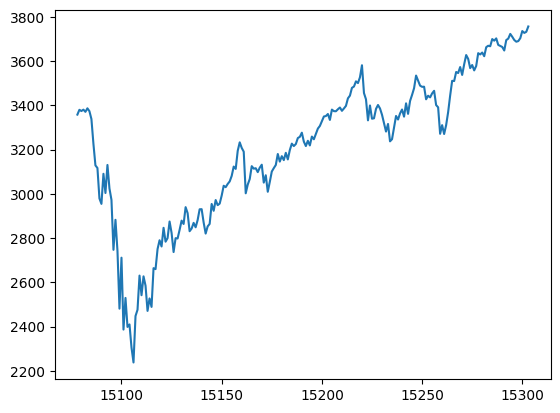

In [162]:
plt.plot(test_data['Close'].iloc[window_size - 1:])

In [166]:
initial_price = test_data['Close'].iloc[window_size - 1]  # Á¨¨28Â§©ÁöÑ‰ª∑Ê†º

# ÈÄöËøáÁ¥ØÁßØÊî∂ÁõäÁéáÊÅ¢Â§ç‰ª∑Ê†º
predicted_price = initial_price * (1 + pd.Series(predicted_return.numpy().flatten())).cumprod()

predicted_price = predicted_price.dropna()

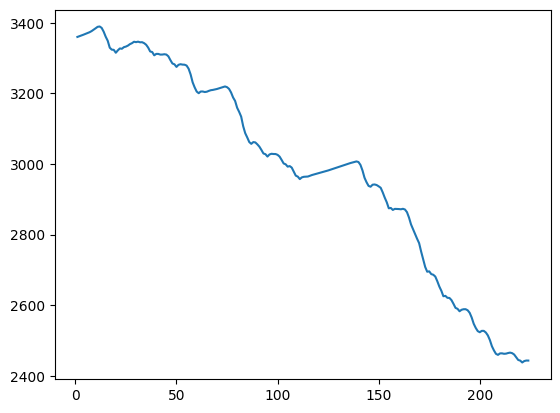

In [167]:
plt.plot(predicted_price)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
true_prices = test_data['Close'].iloc[window_size+1:].values

mae = mean_absolute_error(true_prices, predicted_price)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_price))

print(f"‚úÖ ÊµãËØïÈõÜ MAE: {mae:.2f}, RMSE: {rmse:.2f}")

‚úÖ ÊµãËØïÈõÜ MAE: 532.12, RMSE: 641.45


In [236]:
test_data[28:]

Date    Close     Open     High      Low     PE       MA20  \
15079 2020-02-12  3379.45  3370.50  3381.47  3369.72  30.73  3307.2850   
15080 2020-02-13  3373.94  3365.90  3385.09  3360.52  30.73  3311.5175   
15081 2020-02-14  3380.16  3378.08  3380.69  3366.15  30.73  3314.6850   
15082 2020-02-18  3370.29  3369.04  3375.01  3355.61  30.73  3316.7185   
15083 2020-02-19  3386.15  3380.39  3393.52  3378.83  30.73  3319.9865   
...          ...      ...      ...      ...      ...    ...        ...   
15299 2020-12-24  3703.06  3694.03  3703.82  3689.32  33.77  3680.3145   
15300 2020-12-28  3735.36  3723.03  3740.51  3723.03  33.77  3685.1650   
15301 2020-12-29  3727.04  3750.01  3756.12  3723.31  33.77  3690.4355   
15302 2020-12-30  3732.04  3736.19  3744.63  3730.21  33.77  3693.9150   
15303 2020-12-31  3756.07  3733.27  3760.20  3726.88  33.77  3698.2680   

             EMA10        RSI       MACD  ...  Close_Std_10  Daily_Return  \
15079  3330.557563  66.372258  30.202750  ...     50.012469      0.006463   
15080  3338.445279  65.021817  31.884953  ...     51.780355     -0.001630   
15081  3346.029773  65.866120  33.335740  ...     40.945406      0.001844   
15082  3350.440724  63.256845  33.305151  ...     26.424300     -0.002920   
15083  3356.933319  65.614112  34.166825  ...     20.318086      0.004706   
...            ...        ...        ...  ...           ...           ...   
15299  3691.201113  61.278722  36.431219  ...     21.787600      0.003537   
15300  3699.230001  65.834249  37.531539  ...     23.354510      0.008723   
15301  3704.286365  63.753598  37.302198  ...     16.587076     -0.002227   
15302  3709.332480  64.480123  37.096280  ...     17.779019      0.001342   
15303  3717.830211  67.818671  38.429122  ...     22.503633      0.006439   

       day_of_week  month  quarter  is_month_end  PE_Close_Corr  Sell_Label  \
15079            2      2        1             0      -0.567490           0   
15080            3      2        1             0      -0.600945           0   
15081            4      2        1             0      -0.625291           0   
15082            1      2        1             0      -0.641567           0   
15083            2      2        1             0      -0.653274           0   
...            ...    ...      ...           ...            ...         ...   
15299            3     12        4             0       0.858996           0   
15300            0     12        4             0       0.854354           0   
15301            1     12        4             0       0.845075           0   
15302            2     12        4             0       0.823732           0   
15303            3     12        4             1       0.782147           0   

       label  Close_transformed  
15079      0           0.006463  
15080      0          -0.001630  
15081      0           0.001844  
15082      0          -0.002920  
15083      0           0.004706  
...      ...                ...  
15299      0           0.003537  
15300      0           0.008723  
15301      0          -0.002227  
15302      0           0.001342  
15303      0           0.006439  

[225 rows x 23 columns]

In [251]:
np.mean((predicted_return.squeeze(-1).numpy() - test_data[28:]["Close_transformed"])**2)

np.float64(0.0005247503582863651)

In [252]:
np.mean((predicted_return_base.squeeze(-1).numpy() - test_data[28:]["Close_transformed"])**2)

np.float64(0.0005308950696986374)

In [245]:
0.0005247503582863651 / 0.0005308950696986374

0.9884257515976551

In [ ]:
# Evaluate the RNN model

In [173]:

# 2Ô∏è‚É£ ÁîüÊàê RNN ËæìÂÖ•Ôºà‰ªÖ‰ΩøÁî® Close_transformedÔºâ
X_test_baseline =[]
for i in range(len(test_data) - window_size):
    # ‰ªÖ‰ΩøÁî® Close_transformed ‰Ωú‰∏∫ËæìÂÖ•
    X_test_baseline.append(test_data[['Close_transformed']].iloc[i:i + window_size].values)

X_test_baseline = torch.tensor(np.array(X_test_baseline), dtype=torch.float32).to(device)

In [175]:
# 3Ô∏è‚É£ ‰ΩøÁî® RNN È¢ÑÊµãÊØèÊó• Return
model.eval()
with torch.no_grad():
    predicted_return_baseline,_ = model(X_test_baseline)


RuntimeError: input.size(-1) must be equal to input_size. Expected 2, got 1

In [ ]:

# 4Ô∏è‚É£ Â∞Ü Return ËΩ¨Êç¢Âõû Close Price
initial_price = test_data['Close'].iloc[window_size - 1]  # ‰ª•Á¨¨28Â§©ÁöÑ Close ‰Ωú‰∏∫Âü∫ÂáÜ
predicted_price_baseline = initial_price * (1 + pd.Series(predicted_return_baseline)).cumprod()

# 5Ô∏è‚É£ ËØÑ‰º∞Ê®°ÂûãË°®Áé∞
true_prices = test_data['Close'].iloc[window_size:].values

mae_baseline = mean_absolute_error(true_prices, predicted_price_baseline)
rmse_baseline = np.sqrt(mean_squared_error(true_prices, predicted_price_baseline))

print(f"üìä **Âü∫ÂáÜÊ®°Âûã (‰∏çÂê´ Label)**ÔºöMAE = {mae_baseline:.2f}, RMSE = {rmse_baseline:.2f}")

# 6Ô∏è‚É£ ÂèØËßÜÂåñÁúüÂÆûÂÄº vs È¢ÑÊµãÂÄº
plt.figure(figsize=(14, 8))
plt.plot(true_prices, label='ÁúüÂÆû‰ª∑Ê†º', color='blue')
plt.plot(predicted_price_baseline, label='RNN È¢ÑÊµã‰ª∑Ê†º (Êó† Label)', color='orange')
plt.legend()
plt.xlabel('Êó∂Èó¥')
plt.ylabel('Close Price')
plt.title('RNN È¢ÑÊµãÊïàÊûúÔºö‰∏çÂê´ Sell Label')
plt.grid(True)
plt.show()

In [223]:
base_rnn_model = RNN(input_size=1, output_size=1, hidden_size=64, num_layers=2).to(device)

# ÂàùÂßãÂåñÊ®°Âûã„ÄÅÊçüÂ§±ÂáΩÊï∞Âíå‰ºòÂåñÂô®
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(base_rnn_model.parameters(), lr=1e-4)

# ËÆ≠ÁªÉÂèÇÊï∞
rnn_training_epochs = 100
batch_size = 64

# ËÆ∞ÂΩïËÆ≠ÁªÉÂíåÈ™åËØÅÊçüÂ§±
rnn_train_loss_arr = []
rnn_val_loss_arr = []

# ËÆ≠ÁªÉÊ®°Âûã
for epoch in range(rnn_training_epochs):
    base_rnn_model.train()
    total_train_loss = 0.0

    # Â∞ÜËæìÂÖ•ÂíåÊ†áÁ≠æËΩ¨Êç¢‰∏∫ Variable
    rnn_train_inputv = Variable(X_train[:,:,0].unsqueeze(-1)).to(device)
    rnn_train_labelv = Variable(y_train).to(device)

    # 1. ÂâçÂêë‰º†Êí≠
    output_train, _ = base_rnn_model(rnn_train_inputv)

    # 2. ËÆ°ÁÆóËÆ≠ÁªÉÊçüÂ§±
    loss = criterion(output_train.reshape(-1)[:-1], rnn_train_labelv.view(-1)[1:])
    rnn_train_loss_arr.append(loss.item())
    total_train_loss += loss.item()

    # 3. ÂèçÂêë‰º†Êí≠
    optimizer.zero_grad()
    loss.backward()

    # 4. Êõ¥Êñ∞ÊùÉÈáç
    optimizer.step()

    # È™åËØÅËøáÁ®ã
    base_rnn_model.eval()
    with torch.no_grad():
        rnn_val_inputv = Variable(X_test[:,:,0].unsqueeze(-1)).to(device)
        rnn_val_labelv = Variable(y_test).to(device)

        # ÂâçÂêë‰º†Êí≠
        output_val ,_= base_rnn_model(rnn_val_inputv)

        # ËÆ°ÁÆóÈ™åËØÅÊçüÂ§±
        loss_val = criterion(output_val.reshape(-1)[1:-1], rnn_val_labelv.view(-1)[2:])
        rnn_val_loss_arr.append(loss_val.item())

    # ÊØè10‰∏™epochÊâìÂç∞‰∏ÄÊ¨°ÊçüÂ§±
    if (epoch % 10 == 0 or epoch == rnn_training_epochs - 1):
        print(f"[{epoch}/{rnn_training_epochs}] ËÆ≠ÁªÉÊçüÂ§±: {loss.item():.7f}, È™åËØÅÊçüÂ§±: {loss_val.item():.7f}")

[0/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0001854, È™åËØÅÊçüÂ§±: 0.0005372
[10/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0001114, È™åËØÅÊçüÂ§±: 0.0005360
[20/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000998, È™åËØÅÊçüÂ§±: 0.0005217
[30/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000964, È™åËØÅÊçüÂ§±: 0.0005167
[40/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000953, È™åËØÅÊçüÂ§±: 0.0005147
[50/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000945, È™åËØÅÊçüÂ§±: 0.0005139
[60/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000942, È™åËØÅÊçüÂ§±: 0.0005140
[70/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000942, È™åËØÅÊçüÂ§±: 0.0005146
[80/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000941, È™åËØÅÊçüÂ§±: 0.0005153
[90/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000941, È™åËØÅÊçüÂ§±: 0.0005157
[99/100] ËÆ≠ÁªÉÊçüÂ§±: 0.0000941, È™åËØÅÊçüÂ§±: 0.0005161


In [226]:
base_rnn_model.eval()
with torch.no_grad():
    predicted_return_base, _ = base_rnn_model(X_test[:,:,0].unsqueeze(-1))
predicted_return_base

tensor([[        nan],
        [ 4.2756e-04],
        [ 3.8885e-04],
        [ 3.7611e-04],
        [ 3.8786e-04],
        [ 4.3328e-04],
        [ 3.0859e-04],
        [ 2.1420e-05],
        [-3.8154e-04],
        [-4.1928e-04],
        [ 2.0590e-04],
        [-9.8989e-04],
        [-6.4577e-04],
        [ 1.1862e-03],
        [-9.1117e-04],
        [ 3.4300e-04],
        [ 1.7414e-04],
        [-6.7175e-04],
        [-7.2323e-04],
        [ 1.0250e-03],
        [-4.2996e-04],
        [-3.4312e-03],
        [ 2.4145e-03],
        [-2.0922e-03],
        [-8.7342e-04],
        [ 5.2622e-04],
        [-1.5895e-03],
        [-1.3711e-04],
        [-1.2296e-03],
        [ 2.3095e-03],
        [ 3.2679e-04],
        [ 3.5375e-04],
        [ 4.7329e-04],
        [ 1.0663e-03],
        [ 1.4259e-03],
        [-8.1268e-04],
        [ 1.3152e-03],
        [ 3.7822e-04],
        [ 1.1472e-03],
        [ 6.0958e-04],
        [ 3.7644e-04],
        [ 1.5857e-03],
        [ 2.9806e-04],
        [ 1

In [228]:
initial_price = test_data['Close'].iloc[window_size - 1]  # Á¨¨28Â§©ÁöÑ‰ª∑Ê†º

# ÈÄöËøáÁ¥ØÁßØÊî∂ÁõäÁéáÊÅ¢Â§ç‰ª∑Ê†º
predicted_price_base = initial_price * (1 + pd.Series(predicted_return_base.numpy().flatten())).cumprod()

predicted_price_base = predicted_price_base.dropna()

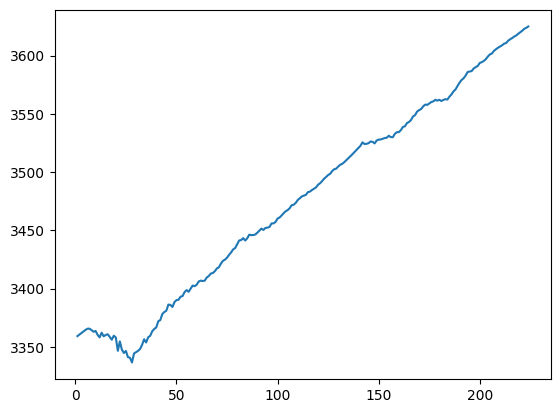

In [229]:
plt.plot(predicted_price_base)

In [231]:
true_prices = test_data['Close'].iloc[window_size+1:].values

mae = mean_absolute_error(true_prices, predicted_price_base)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_price_base))

print(f"‚úÖ ÊµãËØïÈõÜ MAE: {mae:.2f}, RMSE: {rmse:.2f}")

‚úÖ ÊµãËØïÈõÜ MAE: 288.28, RMSE: 376.26
